## 1.3 Research Questions

### This study is guided by four structured research questions:

* What are the common patterns of global food waste observed across various open-source datasets in terms of volume?

* Which key factors contribute most significantly to food waste across different regions, socioeconomic levels, and demographics?

* What is the relationship between food waste generation and environmental indicators such as carbon emissions, land use, and water consumption?

* To what extent do statistical analytics reveal the strength and direction of the relationship between socioeconomic factors and food waste generation?

* In what ways can the findings contribute to achieving Sustainable Development Goal 12 (Responsible Consumption and Production) and related environmental targets?

In [143]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, ttest_ind

In [144]:
# Dataset

faostat_commodities_csv = 'Datasets/faostat-commodities.csv'
annex2_urban_vs_rural_csv = 'Datasets/annex2.csv'
owid_data = 'Datasets/owid_data.csv'
global_estimates = 'Datasets/global_estimates.csv'
food_waste_index_report_2021 = 'Datasets/food-waste-index-report(2021).csv'
food_waste_index_report_2024 = 'Datasets/food-waste-index-report(2024).csv'

In [145]:
# Read CSVsscipy
df_commodities = pd.read_csv(faostat_commodities_csv)
df_urban_rural = pd.read_csv(annex2_urban_vs_rural_csv)
df_global = pd.read_csv(global_estimates)
df_env = pd.read_csv(owid_data)

In [146]:
df_commodities

,Domain,Area,Element,Item,Year,Unit,Value
0,"Food Balances (-2013, old methodology and popu...",Afghanistan,Production,Wheat and products,2011,1000 t,3388.0
1,"Food Balances (-2013, old methodology and popu...",Afghanistan,Production,Wheat and products,2012,1000 t,5050.0
2,"Food Balances (-2013, old methodology and popu...",Afghanistan,Production,Wheat and products,2013,1000 t,5169.0
3,"Food Balances (-2013, old methodology and popu...",Afghanistan,Losses,Wheat and products,2011,1000 t,508.0
4,"Food Balances (-2013, old methodology and popu...",Afghanistan,Losses,Wheat and products,2012,1000 t,758.0
...,...,...,...,...,...,...,...
40822,"Food Balances (-2013, old methodology and popu...",Zimbabwe,Production,Freshwater Fish,2012,1000 t,18.1
40823,"Food Balances (-2013, old methodology and popu...",Zimbabwe,Production,Freshwater Fish,2013,1000 t,18.1
40824,"Food Balances (-2013, old methodology and popu...",Zimbabwe,Production,Crustaceans,2011,1000 t,0.0
40825,"Food Balances (-2013, old methodology and popu...",Zimbabwe,Production,Crustaceans,2012,1000 t,0.0


In [147]:
commodities_df_filtered = df_commodities[df_commodities['Element'].isin(['Production', 'Losses'])]

df_pivot = commodities_df_filtered.pivot_table(
    index=['Area', 'Item', 'Year'],
    columns='Element',
    values='Value',
    aggfunc='sum'
).reset_index()

df_pivot = df_pivot[df_pivot['Production'] > 0]

df_pivot['Loss_Percentage'] = (df_pivot['Losses'] / df_pivot['Production']) * 100

commodity_loss = df_pivot.groupby('Item')['Loss_Percentage'].mean().sort_values(ascending=False)


In [148]:
print(commodity_loss.head(15))

Item
Maize and products                 158.703995
Grapes and products (excl wine)    100.966283
Wheat and products                  65.221269
Soyabeans                           59.256431
Bananas                             46.502731
Barley and products                 35.076199
Butter, Ghee                        28.270644
Palm Oil                            25.897941
Pineapples and products             22.953817
Lemons, Limes and products          20.174779
Rape and Mustardseed                19.887070
Rice (Milled Equivalent)            16.302397
Fruits, other                       15.530666
Beans                               14.335465
Apples and products                 14.075317
Name: Loss_Percentage, dtype: float64


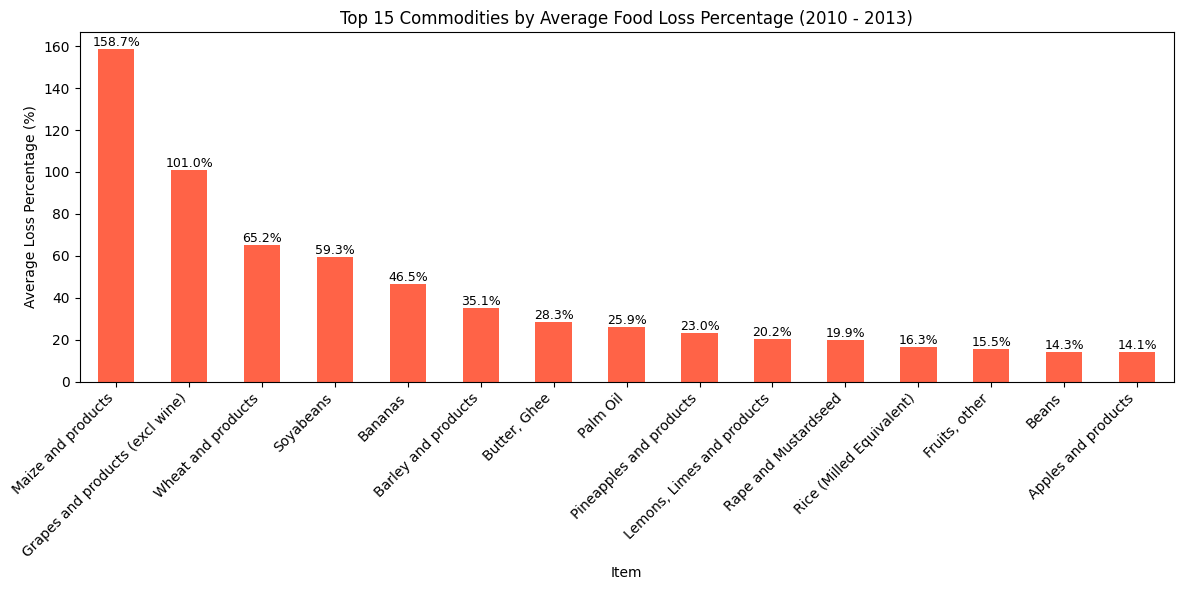

In [149]:
plt.figure(figsize=(12,6))

ax = commodity_loss.head(15).plot(kind='bar', color='tomato')

plt.ylabel('Average Loss Percentage (%)')
plt.title('Top 15 Commodities by Average Food Loss Percentage (2010 - 2013)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=9)

plt.savefig('images/commodity_loss.png')
plt.show()


In [150]:
# Renaming columns

df_global = df_global.rename(columns={
    'M49 Code': 'M49_Code',
    'Household Estimate (kg/capita/year)': 'Household_Estimate_kg_capita_year',
    'Household Estimate (Tonnes/year)': 'Household_Estimate_Tonnes_year'
})

df_urban_rural = df_urban_rural.rename(columns={
    'Study Area': 'Study_Area',
    'Waste Estimate (kg/capita/year)': 'Waste_Estimate_kg_capita_year'
})

df_env = df_env.rename(columns={
    'CO₂ Emissions (Tonnes/Capita)': 'CO2_Per_Capita_Tonnes',
    'GDP Per Capita (USD)': 'GDP_Per_Capita_USD'
})

In [151]:
df_urban_rural[df_urban_rural['Type'] == 'Urban'].describe()

,Waste_Estimate_kg_capita_year
count,8.000000
mean,75.000000
std,22.032444
min,29.000000
25%,70.000000
50%,75.000000
75%,89.750000
max,100.000000


In [152]:
df_urban_rural[df_urban_rural['Type'] == 'Rural'].describe()

,Waste_Estimate_kg_capita_year
count,6.000000
mean,42.000000
std,26.974062
min,6.000000
25%,25.000000
50%,42.500000
75%,56.250000
max,81.000000


=== STATISTICAL ANALYSIS (RQ2) ===
Average Urban Waste: 75.00 kg/capita
Average Rural Waste: 42.00 kg/capita
Gap: Urban centers generate 79% more waste than rural areas.
T-Test p-value: 0.0267 (Significant if < 0.05)


/tmp/ipykernel_8744/2307223545.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_urban_rural, x='Type', y='Waste_Estimate_kg_capita_year', palette='coolwarm')


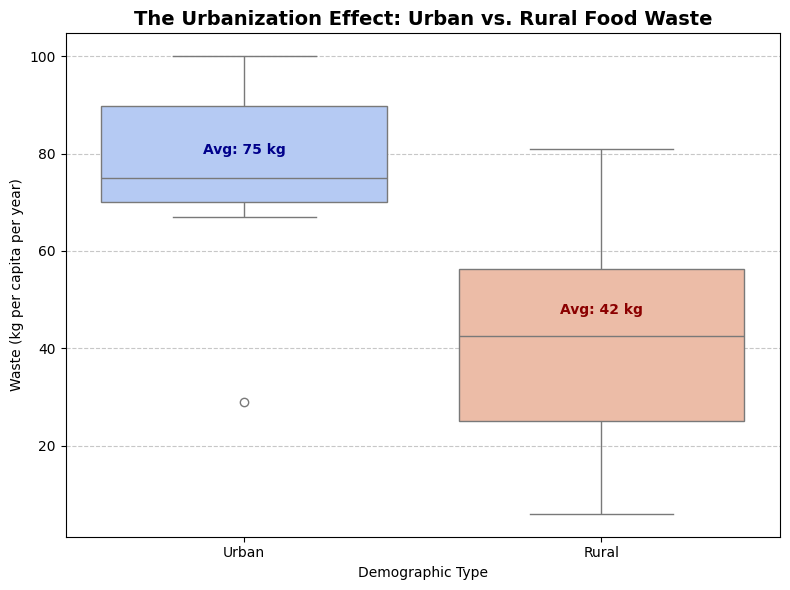

In [153]:
urban_avg = df_urban_rural[df_urban_rural['Type'] == 'Urban']['Waste_Estimate_kg_capita_year'].mean()
rural_avg = df_urban_rural[df_urban_rural['Type'] == 'Rural']['Waste_Estimate_kg_capita_year'].mean()

print(f"=== STATISTICAL ANALYSIS (RQ2) ===")
print(f"Average Urban Waste: {urban_avg:.2f} kg/capita")
print(f"Average Rural Waste: {rural_avg:.2f} kg/capita")
print(f"Gap: Urban centers generate {((urban_avg - rural_avg)/rural_avg)*100:.0f}% more waste than rural areas.")

# Perform T-Test (To prove the gap is real, not random)
t_stat, p_val = ttest_ind(
    df_urban_rural[df_urban_rural['Type'] == 'Urban']['Waste_Estimate_kg_capita_year'],
    df_urban_rural[df_urban_rural['Type'] == 'Rural']['Waste_Estimate_kg_capita_year']
)
print(f"T-Test p-value: {p_val:.4f} (Significant if < 0.05)")

# Generate the Box Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_urban_rural, x='Type', y='Waste_Estimate_kg_capita_year', palette='coolwarm')

# Titles and Labels
plt.title('The Urbanization Effect: Urban vs. Rural Food Waste', fontweight='bold', fontsize=14)
plt.xlabel('Demographic Type')
plt.ylabel('Waste (kg per capita per year)')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotation for the Gap
plt.text(0, urban_avg + 5, f"Avg: {urban_avg:.0f} kg", ha='center', color='darkblue', weight='bold')
plt.text(1, rural_avg + 5, f"Avg: {rural_avg:.0f} kg", ha='center', color='darkred', weight='bold')

plt.tight_layout()
plt.savefig('images/urban_rural.png')
plt.show()

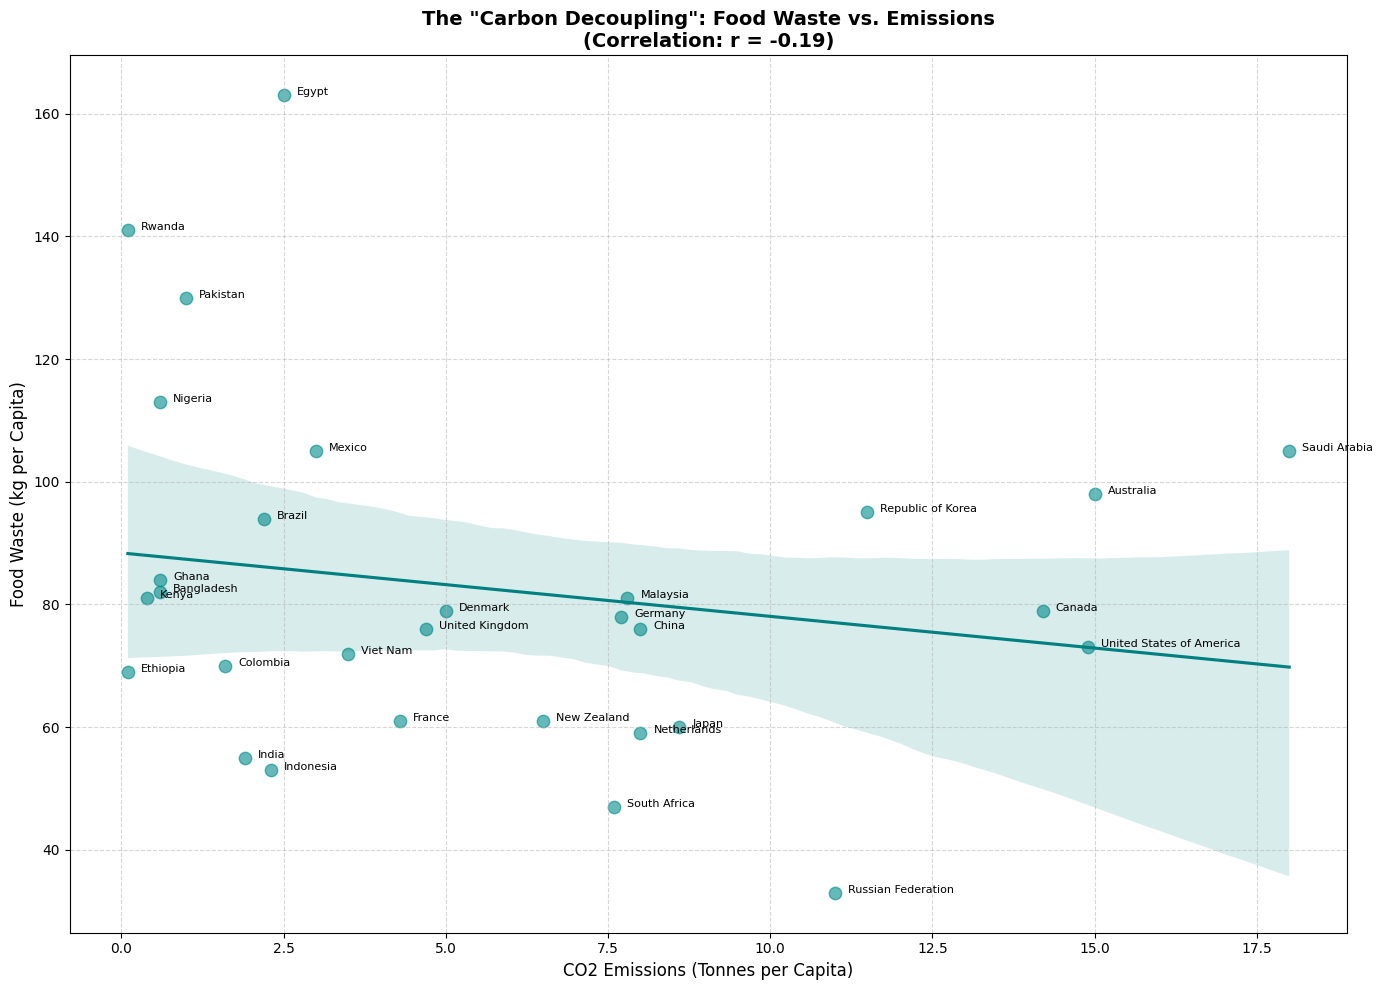

In [154]:
# Data merging

df_merged = pd.merge(df_global, df_env, on='Country', how='inner')

plt.figure(figsize=(14, 10))

# 1. Plot the Data Points with Regression Line
sns.regplot(data=df_merged, x='CO2_Per_Capita_Tonnes', y='Household_Estimate_kg_capita_year',
            scatter_kws={'alpha':0.6, 's':80}, line_kws={'color':'teal'}, color='darkcyan')

# 2. Add Titles and Labels
corr_co2, p_co2 = pearsonr(df_merged['Household_Estimate_kg_capita_year'], df_merged['CO2_Per_Capita_Tonnes'])
plt.title(f'The "Carbon Decoupling": Food Waste vs. Emissions\n(Correlation: r = {corr_co2:.2f})',
          fontweight='bold', fontsize=14)
plt.xlabel('CO2 Emissions (Tonnes per Capita)', fontsize=12)
plt.ylabel('Food Waste (kg per Capita)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# 3. Labeling ALL Countries
# We removed the 'target_countries' filter and now loop through every row
for i, row in df_merged.iterrows():
    plt.text(row['CO2_Per_Capita_Tonnes']+0.2, row['Household_Estimate_kg_capita_year'],
             row['Country'], fontsize=8) # Smaller font to prevent overlap

plt.tight_layout()
plt.savefig('images/carbon_decoupling_all.png')
plt.show()

In [155]:
print(df_merged.dtypes)

Region                                object
M49_Code                               int64
Country                               object
Household_Estimate_kg_capita_year      int64
Household_Estimate_Tonnes_year        object
Confidence                            object
CO2_Per_Capita_Tonnes                float64
GDP_Per_Capita_USD                    object
dtype: object


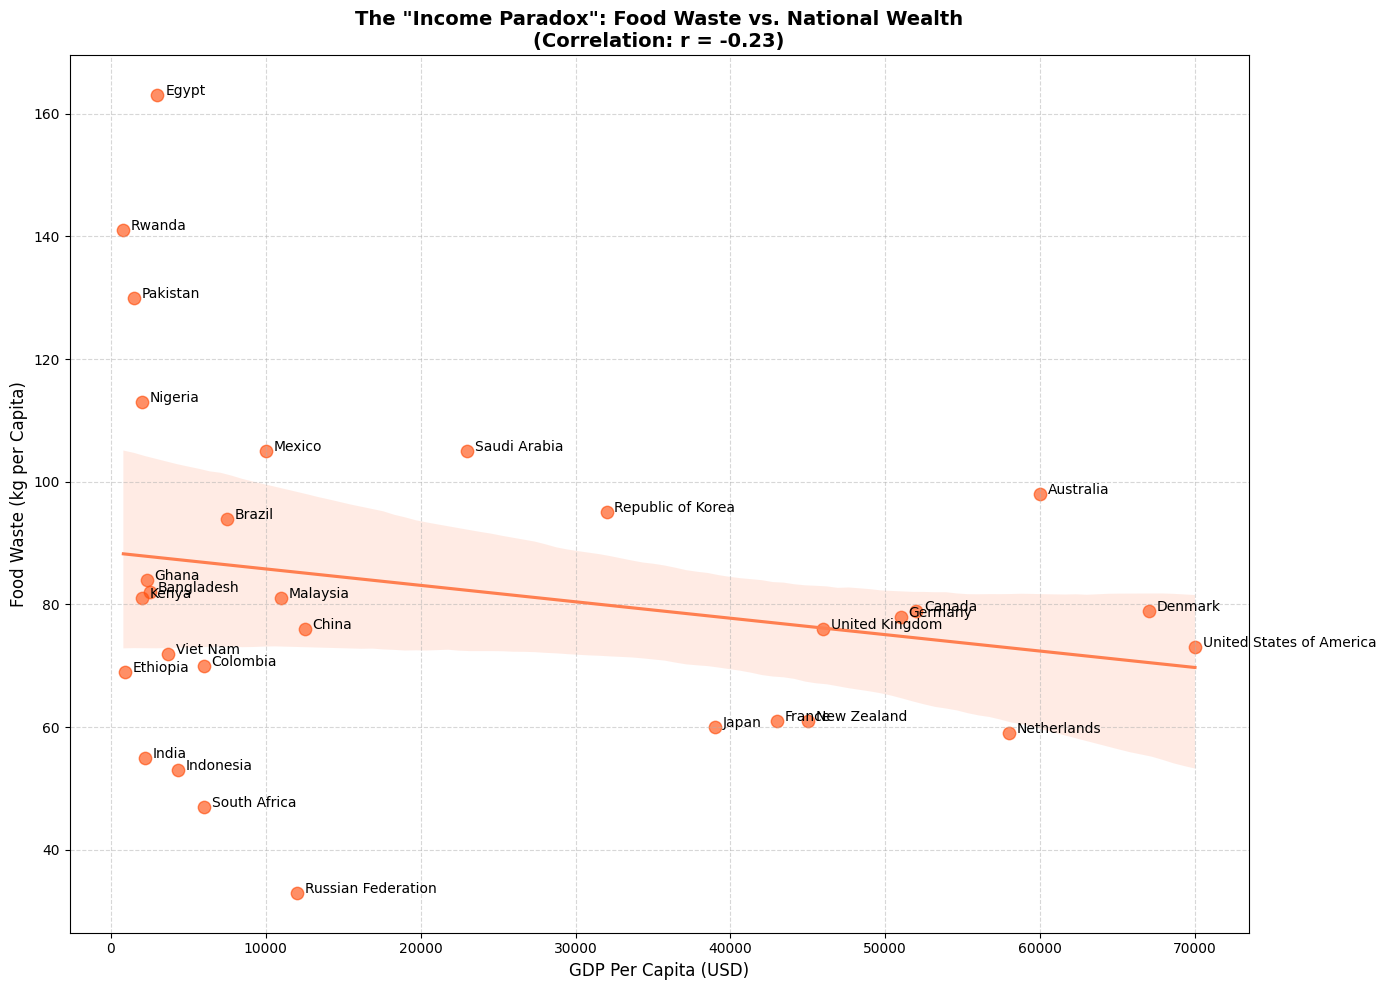

In [156]:
df_merged['GDP_Per_Capita_USD'] = pd.to_numeric(
    df_merged['GDP_Per_Capita_USD'].astype(str).str.replace(',', ''), errors='coerce'
)

# Drop rows with missing numeric values
df_merged = df_merged.dropna(subset=['GDP_Per_Capita_USD', 'Household_Estimate_kg_capita_year'])

# --- Step 2: Plot regression ---
plt.figure(figsize=(14, 10))

sns.regplot(
    data=df_merged,
    x='GDP_Per_Capita_USD',
    y='Household_Estimate_kg_capita_year',
    scatter_kws={'alpha':0.6, 's':80},
    line_kws={'color':'coral'},
    color='orangered'
)

# --- Step 3: Calculate correlation ---
corr_gdp, p_gdp = pearsonr(
    df_merged['Household_Estimate_kg_capita_year'],
    df_merged['GDP_Per_Capita_USD']
)

# --- Step 4: Add titles and labels ---
plt.title(
    f'The "Income Paradox": Food Waste vs. National Wealth\n(Correlation: r = {corr_gdp:.2f})',
    fontweight='bold', fontsize=14
)
plt.xlabel('GDP Per Capita (USD)', fontsize=12)
plt.ylabel('Food Waste (kg per Capita)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# --- Step 5: Label all countries ---
for i, row in df_merged.iterrows():
    plt.text(
        row['GDP_Per_Capita_USD'] + 500,
        row['Household_Estimate_kg_capita_year'],
        row['Country'],
        fontsize=10
    )

plt.tight_layout()
plt.savefig('images/income_paradox.png')
plt.show()

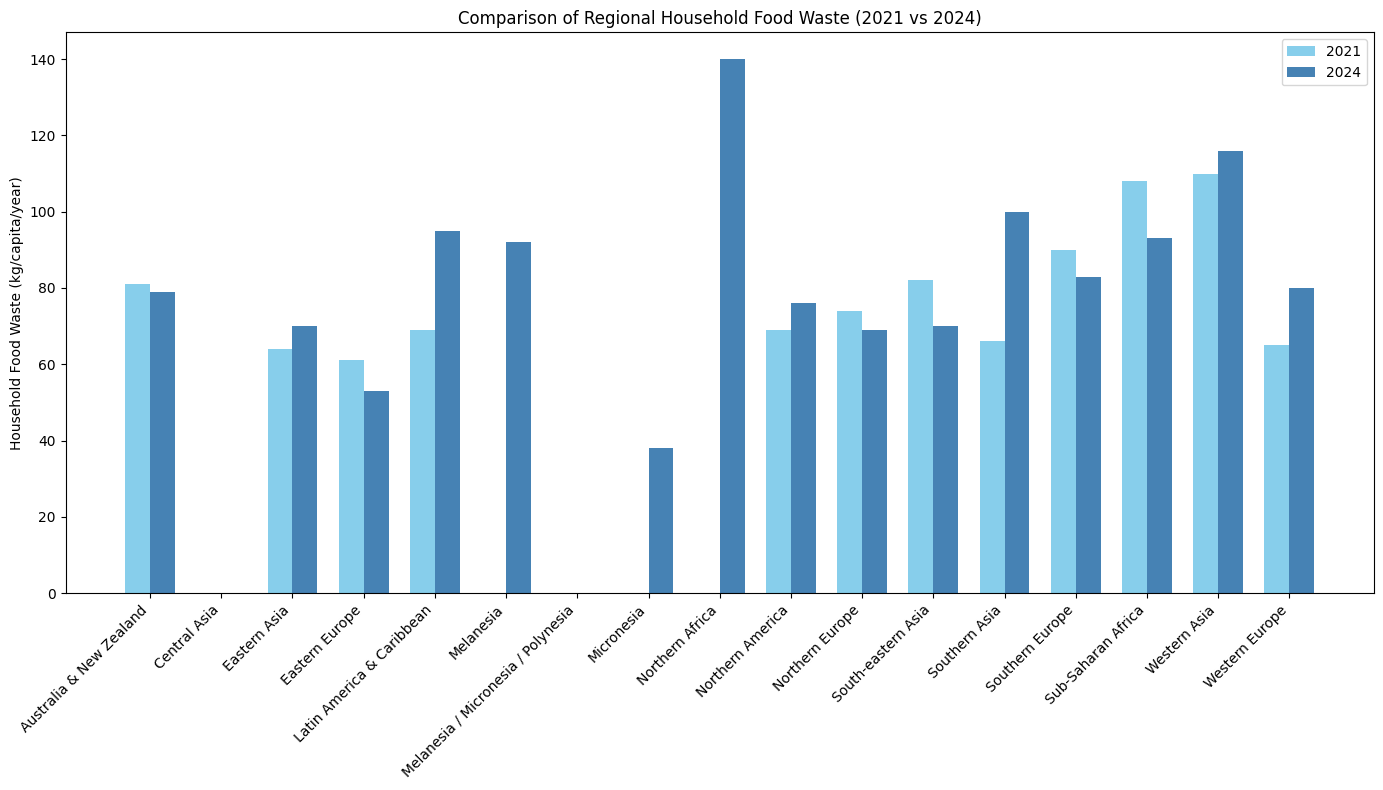

In [157]:
# 1. Load the datasets
# Replace these filenames with your actual csv file paths
df_2021 = pd.read_csv(food_waste_index_report_2021)
df_2024 = pd.read_csv(food_waste_index_report_2024)

# --- STEP 2: RENAMING COLUMNS ---

df_2021 = df_2021.rename(columns={
    'Average Household Food Waste (kg/capita/year)': 'Food Waste'
})

df_2024 = df_2024.rename(columns={
    'Average Household Waste (kg/capita/year)': 'Food Waste'
})

# --- STEP 3: MERGE DATASETS ---

df_merged = pd.merge(df_2024, df_2021, on='Region', how='outer', suffixes=('_2024', '_2021'))

# Fill NaNs with 0 to allow plotting of regions missing in one year
df_merged = df_merged.fillna(0)

# --- STEP 4: PLOTTING ---
regions = df_merged['Region']
waste_2021 = df_merged['Food Waste_2021']
waste_2024 = df_merged['Food Waste_2024']

x = np.arange(len(regions))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(14, 8))

# Create bars: 2021 on the left, 2024 on the right
rects1 = ax.bar(x - width/2, waste_2021, width, label='2021', color='skyblue')
rects2 = ax.bar(x + width/2, waste_2024, width, label='2024', color='steelblue')

# Add labels, title, and legend
ax.set_ylabel('Household Food Waste (kg/capita/year)')
ax.set_title('Comparison of Regional Household Food Waste (2021 vs 2024)')
ax.set_xticks(x)
ax.set_xticklabels(regions, rotation=45, ha='right')
ax.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.savefig('images/Regional-Household-Food-Waste-(2021-vs-2024).png')
plt.show()